# DBSCAN
This notebook uses DBSCAN as a clustering density based approach.



Note: before starting, for reasons of time we could,for this delivery, do the clustering on the full dataset so for now we decided to employ some sort of data reduction as to make it feasible to run such an algorithm

The approach we used was:
- aggregation of races features for each races instance (the year races couple in the dataset)
- remove useless features that don't mean anything after aggregation e.g. stages
- chunking on the dataset reduction every two years to get small enough clusters

In [1]:
import datetime
from sklearn.cluster import DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler
import utils

def most_frequent(series):
    return series.mode()[0] if not series.mode().empty else series.iloc[0]
RACES_PATH=path.join("..","dataset","engineered_races.csv")
races_df=pd.read_csv(RACES_PATH)

#aggregation of races to reduce dataset size and improve clustering quality
aggregated_data=races_df.groupby(['date','stage','std_name','cyclist']).agg({
    'profile':most_frequent,
    'is_tarmac':most_frequent,
    'difficulty_level':most_frequent,

    'points':'sum',

    'length':'mean',
    'climb_total':'mean',
    'competitive_age':'mean',
    'startlist_quality':'mean',
    'delta':'mean',
    'performance_index':'mean',
    'difficulty':'mean',
    'convenience_score':'mean',
    'difficulty_score':'mean',
    'gain_ratio':'mean',

    'cyclist_age':'first',
    'position':'first',
    'cyclist_team':'first',
}).reset_index()

# drop noisy,irrelevant or highly features for clustering

features_to_remove=[
    'is_tarmac','profile','cyclist_team','cyclist','cyclist_team'
]

aggregated_data=aggregated_data.drop(columns=features_to_remove)

#convert to timestamp(units are useless since it's getting normalized)
aggregated_data['date']=pd.to_datetime(aggregated_data['date'])
aggregated_data['day']=aggregated_data['date'].dt.day
aggregated_data['month']=aggregated_data['date'].dt.month
aggregated_data['year']=aggregated_data['date'].dt.year

#one hot encoding difficulty
ohe_diff_lvl=pd.get_dummies(races_df['difficulty_level']).astype(float)
aggregated_data[ohe_diff_lvl.columns]=ohe_diff_lvl

aggregated_data=utils.random_sampling_reduce(aggregated_data,0.5)

clustering_data=aggregated_data.copy()
aggregated_data=aggregated_data.drop(columns='date')



#dividing into chunks
#dec_cut=pd.date_range(
#    start=clustering_data['date'].min(),
#    end=clustering_data['date'].max(),
#    freq='2YE'
#)
#apply chunks
#clustering_data['decade']=pd.cut(
#    clustering_data['date'],
#    bins=dec_cut,
#)
#remove useless columns
#clustering_data=clustering_data.drop(columns="date")

#clustering_data

In [2]:
import utils

print(aggregated_data.shape)

cat_cols=aggregated_data.select_dtypes(include=['object','bool']).columns

one_hot_enc=pd.get_dummies(aggregated_data[cat_cols])


aggregated_data[one_hot_enc.columns]=one_hot_enc

aggregated_data=aggregated_data.drop(columns=cat_cols)

#aggregated_data=utils.random_sampling_reduce(aggregated_data,0.5)

aggregated_data

(294870, 22)


,points,length,climb_total,competitive_age,startlist_quality,delta,performance_index,difficulty,convenience_score,difficulty_score,...,std_name_tour-de-france,std_name_tour-de-romandie,std_name_tour-de-suisse,std_name_uae-tour,std_name_volta-a-catalunya,std_name_vuelta-a-espana,std_name_world-championship,difficulty_level_easy,difficulty_level_hard,difficulty_level_moderate
570307,225.0,224800.0,4147.000000,24.0,724.0,249.0,0.598496,69991.324896,0.019480,1.508616,...,False,False,False,False,False,False,False,False,False,True
345525,50.0,154500.0,1212.000000,24.0,1038.0,0.0,0.361722,15640.714979,0.019371,0.629041,...,False,False,False,False,False,False,False,True,False,False
219654,50.0,172000.0,2330.469215,26.0,926.0,0.0,0.506904,46616.141977,0.006497,0.841393,...,False,False,False,False,False,False,False,True,False,False
37891,80.0,175000.0,1616.000000,26.0,925.0,0.0,0.226384,6070.796005,0.079862,0.747818,...,False,False,False,False,False,True,False,True,False,False
469152,50.0,182000.0,2277.000000,30.0,883.0,1185.0,0.203008,427833.019634,0.000705,1.863397,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367565,275.0,298000.0,2380.000000,34.0,1079.0,20.0,0.384962,47998.012820,0.034720,1.472384,...,False,False,False,False,False,False,False,False,False,True
376313,50.0,124500.0,2375.000000,26.0,1117.0,38.0,0.389337,22719.497366,0.013334,1.206830,...,False,False,False,False,False,False,False,False,False,True
104125,80.0,220000.0,2330.469215,29.0,1034.0,295.0,0.361722,8426.020566,0.057538,1.483826,...,False,False,False,False,False,False,False,False,False,True
39783,100.0,195000.0,3500.000000,22.0,1470.0,1436.0,0.201230,20350.448230,0.029778,2.077389,...,True,False,False,False,False,False,False,False,True,False


# bulk clustering
For a first test we can do bulk clustering i.e. try on the whole dataset.

First we must pick the values, for the minpts we use some heuristics to pick the values.

For MinPts we pick $2*D$ with $D$ equal to the dimensionality of the dataset.

For $Eps$ we try the elbow method to graphically detect the best eps value using the elbow method.

We can try various methods.

In [14]:
from sklearn.neighbors import NearestNeighbors
import utils
import numpy as np
import matplotlib.pyplot as plt
import math

std_scaler=StandardScaler()

min_pts=max(math.ceil(len(aggregated_data)/(2*2*2*2*2*2*2)),10001)

norm_aggregated_data=std_scaler.fit_transform(aggregated_data)

nn=NearestNeighbors(n_neighbors=min_pts,n_jobs=-1).fit(norm_aggregated_data)
distances,indices= nn.kneighbors(norm_aggregated_data,n_neighbors=min_pts)



MemoryError: Unable to allocate 22.0 GiB for an array with shape (294870, 10001) and data type int64

So after computing the distances weneed to selelct a good initial eps value or our tests to do so we need to start somewhere,

[[ 2.48777518e+00  8.98505769e-01  1.52126248e+00 ... -6.80118925e-01
  -3.54588499e-01  8.64941411e-01]
 [-7.22475979e-01 -1.91140334e-01 -9.38153869e-01 ...  1.47033109e+00
  -3.54588499e-01 -1.15614767e+00]
 [-7.22475979e-01  8.01086957e-02 -9.19975784e-04 ...  1.47033109e+00
  -3.54588499e-01 -1.15614767e+00]
 ...
 [-1.72147209e-01  8.24106035e-01 -9.19975784e-04 ... -6.80118925e-01
  -3.54588499e-01  8.64941411e-01]
 [ 1.94738638e-01  4.36607421e-01  9.79101535e-01 ... -6.80118925e-01
   2.82017043e+00 -1.15614767e+00]
 [-1.72147209e-01 -2.04648370e+00 -1.34791693e+00 ...  1.47033109e+00
  -3.54588499e-01 -1.15614767e+00]]
294860 20.76199362719406


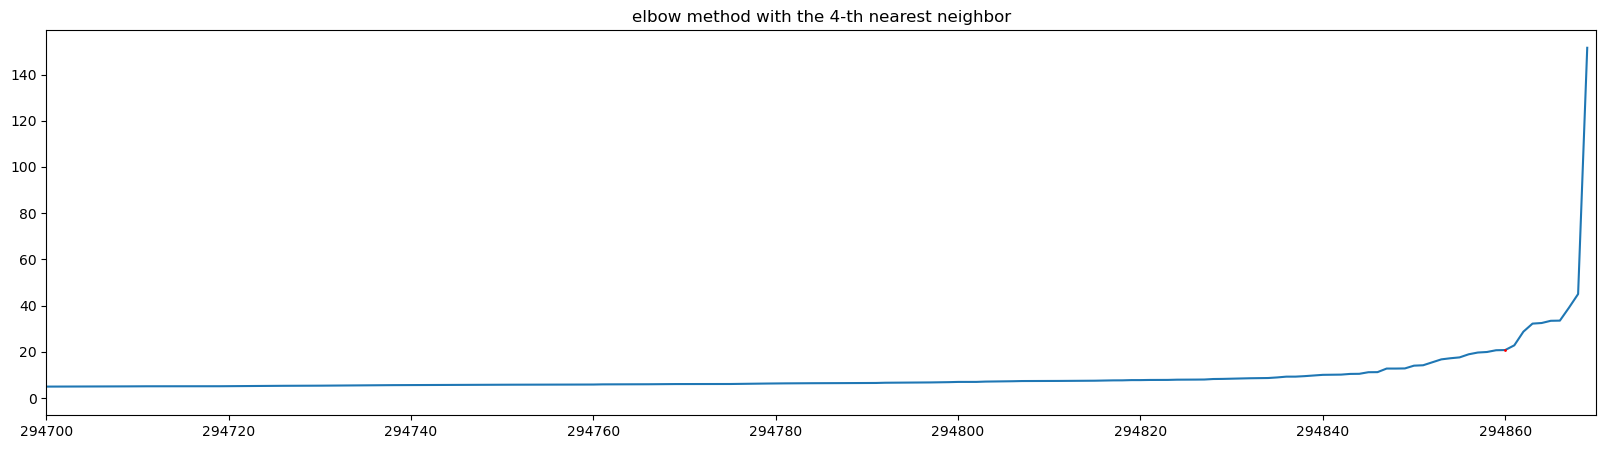

294860 33.98479903104441


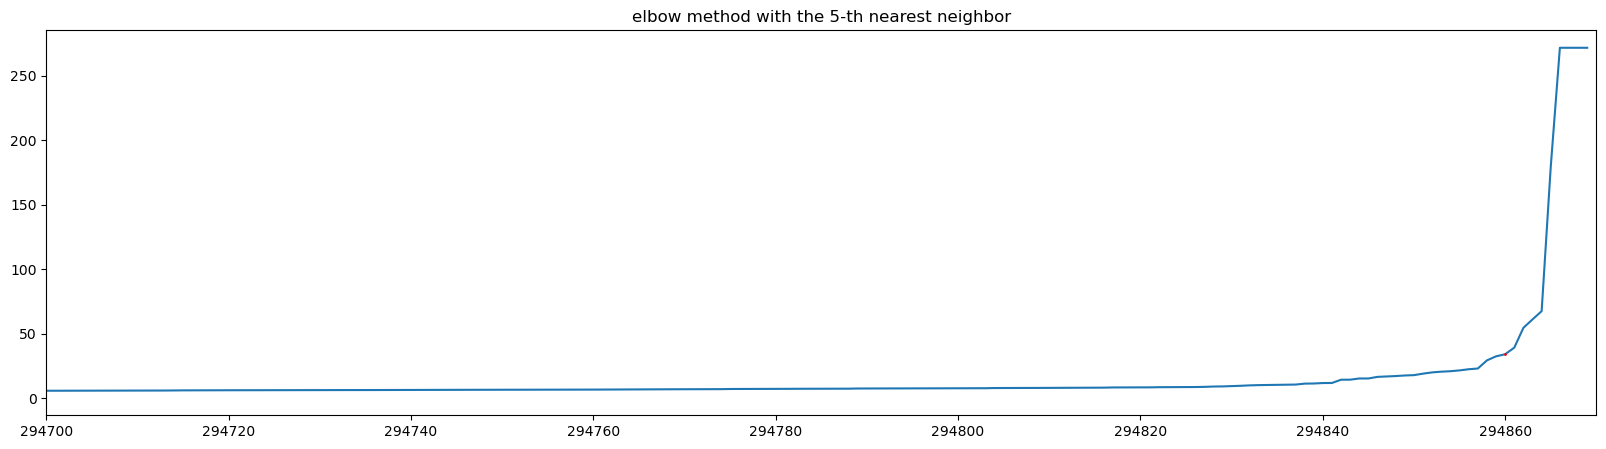

294860 221.72646985294108


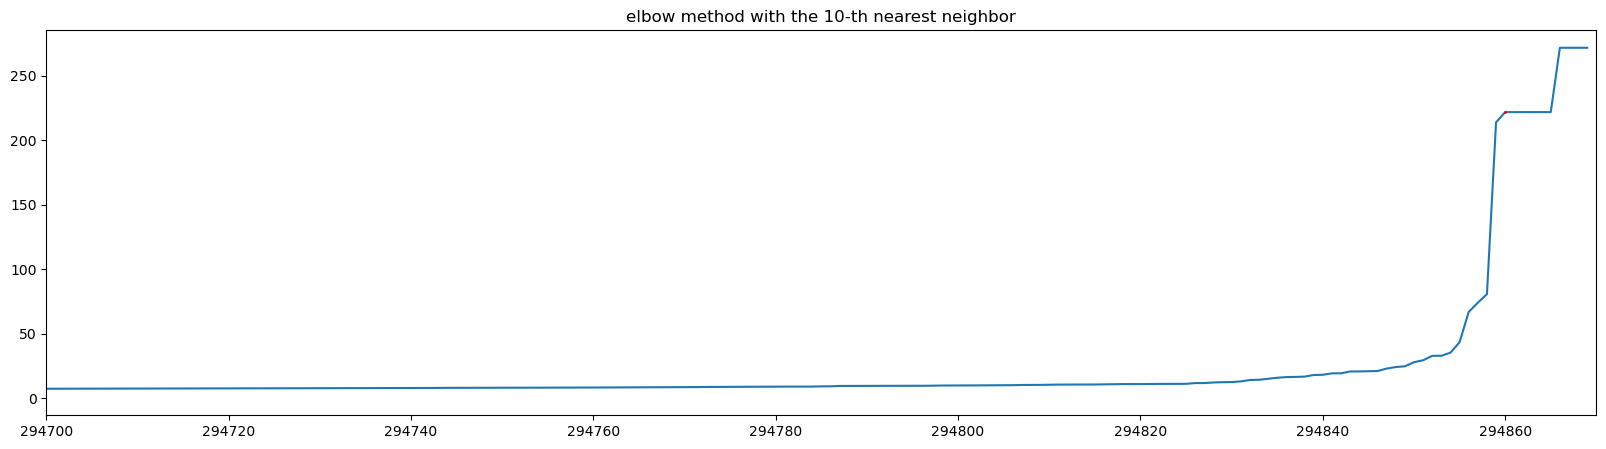

294860 221.7324867493561


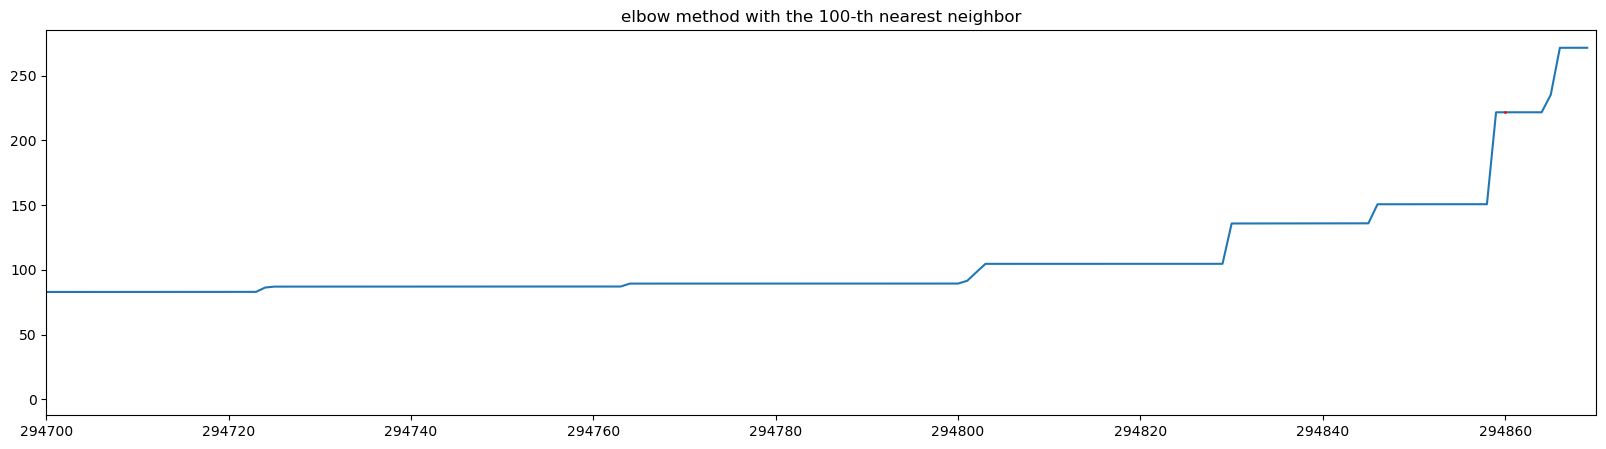

294860 221.74187157883603


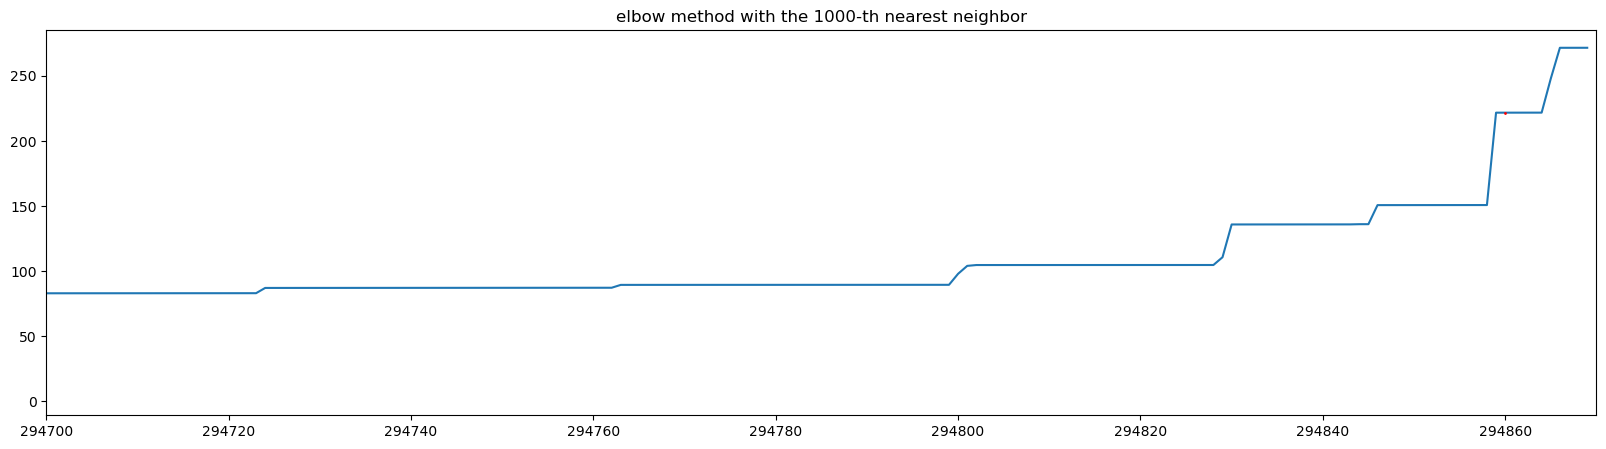

IndexError: index 9999 is out of bounds for axis 1 with size 2304

In [ ]:


sorted_dists=[]

n_dim=aggregated_data.shape[1]

kth_neighbors=[
    4,
    5,
    10,
    100,
    1000,

]

print(norm_aggregated_data)

for k in kth_neighbors:  
    k_distances= np.sort(distances[:,k-1])
    plt.figure(figsize=(20,5))
    plt.plot(k_distances)
    print(k_th_idx,k_distances[k_th_idx])
    plt.plot(k_th_idx,k_distances[k_th_idx],marker='o',markersize=1,color='red')
    #plt.xlim(294860,len(k_distances))
    plt.title(f"elbow method with the {k}-th nearest neighbor")
    plt.show()
    sorted_dists.append(k_distances)

Ok so by using this heuristi we can see a first elbow and can try dbscan on the whole dataset using the minimum configuration.

A good for $MinPts$ heuristic seems to be $2*\text{dimension of dataset}$ which was proposed during the lectures, given the dimensionality o the dataset i could be enough so building on such approach we could tackle a possible grid by using different values at different scales possibly. Such approach also respects the orinal DBSCAN paper proposal which proposed ate least te dimensionality+1 as a starting point.

As for $Eps$ the most suitable way seems to be trial and error by usin the graphical method above and using different values to test different values, the original paper in it'experiments used the 4-th nearest neighbor for an estimate and our trials confirmed it to be the most suitable approach.

The result which obtained at least some degree of clustering even if very low seems to be with an eps value of almost 20 on the "knee" in graph above, it seems reasonable that for fine tuning we should have.

In [15]:
import itertools as it

maximum_distance=abs(norm_aggregated_data.max()-norm_aggregated_data.min()).sum().item()
average_concentration= norm_aggregated_data.shape[0]/maximum_distance

print(f"""
maximum distance : {maximum_distance}
average concentration : {average_concentration}
""")

n_dim=norm_aggregated_data.shape[1]




results_df=utils.run_dbscan(
    min_pts_values=[
        4,#from the elbow method
        n_dim+1,#from the original DBSCAN paper
        2*n_dim,#from the heuristics seen at laboratory
        5*n_dim,#tryig various scales for the min pts values
        10*n_dim,#from the heuristics seen at laboratory
        20*n_dim,#from the heuristics seen at laboratory#from the previous elbow method application
        50*n_dim,
        100*n_dim,
        1000*n_dim

        ],
    eps_values=it.chain(
        average_concentration*np.array([10,5,2.5,1,0.1,0.01,0.0001]),
        21*np.array([10,5,2.5,1,0.1,0.01,0.0001]),#from the previous elbow method application for different scales,
        25*np.array([10,5,2.5,1,0.1,0.01,0.0001]),#from the previous elbow method application for different scales,
        100*np.array([10,5,2.5,1,0.1,0.01,0.0001]),#from the previous elbow method application for different scales,
        ),
    metric=['euclidean'],
    clustering_data=norm_aggregated_data
)

results_df


maximum distance : 278.5701796308198
average concentration : 1058.512438017529

Running DBSCAN: 0 - eps=10585.12438017529, metric=euclidean, min_samples=4
DBSCAN done in 1623.24 seconds | Silhouette Score: 0.006673767376945547
Running DBSCAN: 1 - eps=10585.12438017529, metric=euclidean, min_samples=106
DBSCAN done in 0.57 seconds | Silhouette Score: all noise
Running DBSCAN: 2 - eps=10585.12438017529, metric=euclidean, min_samples=210
DBSCAN done in 0.53 seconds | Silhouette Score: all noise
Running DBSCAN: 3 - eps=10585.12438017529, metric=euclidean, min_samples=525
DBSCAN done in 0.52 seconds | Silhouette Score: all noise
Running DBSCAN: 4 - eps=10585.12438017529, metric=euclidean, min_samples=1050
DBSCAN done in 0.52 seconds | Silhouette Score: all noise
Running DBSCAN: 5 - eps=10585.12438017529, metric=euclidean, min_samples=2100
DBSCAN done in 0.52 seconds | Silhouette Score: all noise
Running DBSCAN: 6 - eps=10585.12438017529, metric=euclidean, min_samples=5250
DBSCAN done in 0.

,group_index,eps,metric,min_samples,silhouette_score,execution_time(s)
0,0,10585.12438,euclidean,4,0.006674,1623.236393
0,1,10585.12438,euclidean,106,all noise,0.573163
0,2,10585.12438,euclidean,210,all noise,0.525168
0,3,10585.12438,euclidean,525,all noise,0.515839
0,4,10585.12438,euclidean,1050,all noise,0.521962
...,...,...,...,...,...,...
0,247,0.01000,euclidean,1050,all noise,0.525758
0,248,0.01000,euclidean,2100,all noise,0.535756
0,249,0.01000,euclidean,5250,all noise,0.522950
0,250,0.01000,euclidean,10500,all noise,0.533068


In [16]:
results_df.loc[results_df['silhouette_score']=='all noise',['silhouette_score']]=-1


results_df[results_df['silhouette_score']>=0].sort_values(by='silhouette_score',ascending=False)

,group_index,eps,metric,min_samples,silhouette_score,execution_time(s)
0,0,10585.124380,euclidean,4,0.006674,1623.236393
0,9,5292.562190,euclidean,4,0.006674,1634.349515
0,225,10.000000,euclidean,4,0.006674,1646.114320
0,216,100.000000,euclidean,4,0.006674,1651.144262
0,207,250.000000,euclidean,4,0.006674,1649.899165
0,198,500.000000,euclidean,4,0.006674,1648.752501
0,189,1000.000000,euclidean,4,0.006674,1654.085301
0,162,2.500000,euclidean,4,0.006674,1650.547891
0,153,25.000000,euclidean,4,0.006674,1652.170159
0,144,62.500000,euclidean,4,0.006674,1651.844362


From the bulk cluster we don't know what to expect, given the very heterogenous nature of the attributes probably we won't be ale to find good results, however applying the elbow method is still a good idea, if on the whole cluster we manage o find a good eps we can reuse it if we want segments to study dnsity acroos diferent groupings of the data.

# clustering organization

A few notes are due before starting, first the eps are difficulty to setup for now a good strategy would be to take inspiration using the first paper the introduced the algorithm, which you can find [here](https://dl.acm.org/doi/10.5555/3001460.3001507), and use the distance from the k-th NN varying K until we find a good eps value for us.

A few notes before starting, for DBSCAN only the silhoutte score is used since BSS and SSE are not meaningful given the nature of the algorithm and fail to caputure meaningufl details about the clusterings.

## applying the elbow method
In this part since it is diifcult to estimate values we picked a kth neighbor that is not too low to have an eps taht is higher and manages to reach more points.

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import itertools as it
import numpy as np
import utils
clustering_data=clustering_data.drop(columns=["difficulty_level","stage","std_name","cyclist","cyclist_team","easy","hard","moderate","is_tarmac","gain_ratio","difficulty_score","position"]).drop_duplicates()

std_scaler=StandardScaler()

print(clustering_data.columns)

dec_groups=clustering_data.groupby('decade')
normalized_decade_groups={k:std_scaler.fit_transform(g.drop(columns="decade").drop_duplicates()) for k,g in dec_groups }

print({k:len(g) for k,g in normalized_decade_groups.items()})

initial_eps=dict()

kth_neighbor=30

kth_neighbors=[
    4,# value ued in theoriginal DBSCAN paper
    clustering_data.shape[1]+1,# common heuristics used to pick kth_neighbors 
    2*clustering_data.shape[1]
    ]

for k,data in normalized_decade_groups.items():
    min_pts=data.shape[1]
    nn=NearestNeighbors(n_neighbors=min_pts-1,n_jobs=-1)
    nn.fit(data)
    distances,indices= nn.kneighbors(data)
    k_distances= np.sort(distances[:, -1])

    initial_eps[k]=k_distances[kth_neighbor-1]


print(f"""
number of groups={len(normalized_decade_groups)}
initial eps values per group={initial_eps}
""")

Index(['profile', 'points', 'length', 'climb_total', 'competitive_age',
       'startlist_quality', 'delta', 'performance_index', 'difficulty',
       'convenience_score', 'cyclist_age', 'day', 'month', 'year', 'decade'],
      dtype='object')
{Interval(1970-12-31 00:00:00, 1972-12-31 00:00:00, closed='right'): 753, Interval(1972-12-31 00:00:00, 1974-12-31 00:00:00, closed='right'): 459, Interval(1974-12-31 00:00:00, 1976-12-31 00:00:00, closed='right'): 1233, Interval(1976-12-31 00:00:00, 1978-12-31 00:00:00, closed='right'): 3686, Interval(1978-12-31 00:00:00, 1980-12-31 00:00:00, closed='right'): 7789, Interval(1980-12-31 00:00:00, 1982-12-31 00:00:00, closed='right'): 9836, Interval(1982-12-31 00:00:00, 1984-12-31 00:00:00, closed='right'): 11363, Interval(1984-12-31 00:00:00, 1986-12-31 00:00:00, closed='right'): 11256, Interval(1986-12-31 00:00:00, 1988-12-31 00:00:00, closed='right'): 10791, Interval(1988-12-31 00:00:00, 1990-12-31 00:00:00, closed='right'): 10995, Interval(1990

/tmp/ipykernel_12081/3409638663.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dec_groups=clustering_data.groupby('decade')



number of groups=26
initial eps values per group={Interval(1970-12-31 00:00:00, 1972-12-31 00:00:00, closed='right'): 0.9155102427433038, Interval(1972-12-31 00:00:00, 1974-12-31 00:00:00, closed='right'): 1.3017056548170938, Interval(1974-12-31 00:00:00, 1976-12-31 00:00:00, closed='right'): 0.8180223071229451, Interval(1976-12-31 00:00:00, 1978-12-31 00:00:00, closed='right'): 0.5231390365005472, Interval(1978-12-31 00:00:00, 1980-12-31 00:00:00, closed='right'): 0.4627659081819203, Interval(1980-12-31 00:00:00, 1982-12-31 00:00:00, closed='right'): 0.4631630266953081, Interval(1982-12-31 00:00:00, 1984-12-31 00:00:00, closed='right'): 0.4465417852131229, Interval(1984-12-31 00:00:00, 1986-12-31 00:00:00, closed='right'): 0.45026786677913466, Interval(1986-12-31 00:00:00, 1988-12-31 00:00:00, closed='right'): 0.46040209204023885, Interval(1988-12-31 00:00:00, 1990-12-31 00:00:00, closed='right'): 0.4565313815062814, Interval(1990-12-31 00:00:00, 1992-12-31 00:00:00, closed='right'):

Now that we have the sorted distances we can pick the eps values and proceed to test dbscan , in this case we have more starting eps values given the segmentation hance we have a lot of tests to do.


NOTE: since we didn't manage to make execution feasible we had to cut the clusterings and we go only from 1970 to 1994 with jumps of two years

NOTE: DBSCAN relies a lot on the density we where afraid that sampling would make clustering meaningless because of too many points removed and having a too approximated distribution.

In [3]:

# useful for reference
db_scan_mapping={
    -1:'noisy',
    0:'border',
    1:'core'

}

group_results=pd.DataFrame()


for k,decade_data in normalized_decade_groups.items():
    #NOTE: this might have to be revisited for it's just to try if everyting works
    dimension=decade_data.shape[0]
    min_pts=int(dimension-1)
    #using the method seen at laboratory to select initial values
    #print(decade_data.drop(columns="decade").info())
    maximum_distance = abs(decade_data.max() - decade_data.min()).sum().item()
    average_concentration = dimension / maximum_distance
    #use diferent scales for eps values
    # during the tests a lot of low values where not taken into consideration
    eps_values=initial_eps[k] * np.array([500,250,100,50,10, 5, 2.5, 1, 0.1, 0.01, 0.0001])
    #try various metrics
    metrics=['euclidean']

    min_pts_values=[min_pts]
    print(
    f"""
    period {k}
    maxium distance: {maximum_distance}
    average concentration:{average_concentration}
    eps values:{eps_values}
    used metrics:{metrics}
    number of minimum samples:{min_pts}
    number of samples used:{decade_data.shape[0]}
    """
    )
    #normalization is done for each group
    result=utils.run_dbscan(min_pts_values,eps_values,metrics,decade_data)
    result["group"]=k
    group_results=pd.concat([group_results,result])
group_results.reset_index()


    period (1970-12-31 00:00:00, 1972-12-31 00:00:00]
    maxium distance: 26.4432145906155
    average concentration:28.476114256820882
    eps values:[4.57755121e+02 2.28877561e+02 9.15510243e+01 4.57755121e+01
 9.15510243e+00 4.57755121e+00 2.28877561e+00 9.15510243e-01
 9.15510243e-02 9.15510243e-03 9.15510243e-05]
    used metrics:['euclidean']
    number of minimum samples:752
    number of samples used:753
    
Running DBSCAN: 0 - eps=457.7551213716519, metric=euclidean, min_samples=752
DBSCAN done in 0.00 seconds | Silhouette Score: all noise
Running DBSCAN: 1 - eps=228.87756068582596, metric=euclidean, min_samples=752
DBSCAN done in 0.00 seconds | Silhouette Score: all noise
Running DBSCAN: 2 - eps=91.55102427433039, metric=euclidean, min_samples=752
DBSCAN done in 0.00 seconds | Silhouette Score: all noise
Running DBSCAN: 3 - eps=45.775512137165194, metric=euclidean, min_samples=752
DBSCAN done in 0.00 seconds | Silhouette Score: all noise
Running DBSCAN: 4 - eps=9.155102427

,index,SSE,BSS,group_index,eps,metric,min_samples,silhouette_score,execution_time(s),group
0,0,not needed,not needed,0,457.755121,euclidean,752,all noise,0.001918,"(1970-12-31 00:00:00, 1972-12-31 00:00:00]"
1,0,not needed,not needed,1,228.877561,euclidean,752,all noise,0.001915,"(1970-12-31 00:00:00, 1972-12-31 00:00:00]"
2,0,not needed,not needed,2,91.551024,euclidean,752,all noise,0.001148,"(1970-12-31 00:00:00, 1972-12-31 00:00:00]"
3,0,not needed,not needed,3,45.775512,euclidean,752,all noise,0.000931,"(1970-12-31 00:00:00, 1972-12-31 00:00:00]"
4,0,not needed,not needed,4,9.155102,euclidean,752,all noise,0.001391,"(1970-12-31 00:00:00, 1972-12-31 00:00:00]"
...,...,...,...,...,...,...,...,...,...,...
281,0,not needed,not needed,6,1.000888,euclidean,39698,all noise,0.025224,"(2020-12-31 00:00:00, 2022-12-31 00:00:00]"
282,0,not needed,not needed,7,0.400355,euclidean,39698,all noise,0.023848,"(2020-12-31 00:00:00, 2022-12-31 00:00:00]"
283,0,not needed,not needed,8,0.040036,euclidean,39698,all noise,0.024552,"(2020-12-31 00:00:00, 2022-12-31 00:00:00]"
284,0,not needed,not needed,9,0.004004,euclidean,39698,all noise,0.025165,"(2020-12-31 00:00:00, 2022-12-31 00:00:00]"


As for the result we only managed to find a meaningful clustering in th first two years with a silhoutte score of 0.79 all the otehr are all noise , however after some consideration we found out that we don't have any meaningful clusteriong because we have all points taht are core so eps is too high bnut lowering it doesn't change even after testing very different scales both big and small.

In [4]:
best_idx=0
best_params=group_results.iloc[best_idx]

best_dbscan=DBSCAN(eps=best_params['eps'],min_samples=best_params['min_samples']).fit(normalized_decade_groups[best_params['group']])

labels=best_dbscan.labels_

statistics=np.unique(best_dbscan.labels_,return_counts=True)

print(
f"""
results:{best_params}
statistics:
    raw counts: noise {statistics[0][0]}| core {statistics[1][0]}
"""
)





results:SSE                                                  not needed
BSS                                                  not needed
group_index                                                   0
eps                                                  457.755121
metric                                                euclidean
min_samples                                                 752
silhouette_score                                      all noise
execution_time(s)                                      0.001918
group                (1970-12-31 00:00:00, 1972-12-31 00:00:00]
Name: 0, dtype: object
statistics:
    raw counts: noise 0| core 753



So for this first delivery we can only say taht after some consideration the dataset tends to be very sparse, probably some sensd approaches would be to:
- use sampling and make a bigger hyperparameters space.
- find a more refined method to select the eps values.
- use different segmentations.

As you can see clustyring by years even after trying to reduce the dimension to get less sparse clusters is not effective, aside from a nice 0.71 in the first part we cannot get much more than that, we can infer very different densities across years which makes for very bad clusterings.

So we can try other kind of segmentations, a first approach could be geospatial: group by the race occurencies across time.

## geospatial clustering

In [2]:
ohe_diff_lvl=pd.get_dummies(races_df['difficulty_level']).astype(float)
clustering_data[ohe_diff_lvl.columns]=ohe_diff_lvl

ohe_tarmac=pd.get_dummies(races_df['is_tarmac']).astype(float)

cols=list(ohe_tarmac.columns)
cols[0]='True_is_tarmac'
cols[1]='False_is_tarmac'
clustering_data[cols]=ohe_tarmac


clustering_data=clustering_data.drop(columns=["cyclist","cyclist_team","is_tarmac","difficulty_level","date","stage"]).drop_duplicates()

std_scaler=StandardScaler()

clustering_data=utils.random_sampling_reduce(clustering_data,0.25)

races_groups=clustering_data.groupby('std_name')
normalized_races_groups={k:std_scaler.fit_transform(g.drop(columns="std_name").drop_duplicates()) for k,g in races_groups }

print({k:len(g) for k,g in normalized_races_groups.items()})

initial_eps=dict()

kth_neighbor=4

for k,data in normalized_races_groups.items():
    min_pts=data.shape[1]
    nn=NearestNeighbors(n_neighbors=min_pts-1,n_jobs=-1)
    nn.fit(data)
    distances,indices= nn.kneighbors(data)
    k_distances= np.sort(distances[:, -1])

    initial_eps[k]=k_distances[kth_neighbor-1]


print(f"""
number of groups={len(normalized_races_groups)}
initial eps values per group={initial_eps}
""")

{'amstel-gold-race': 1108, 'dauphine': 6671, 'dwars-door-vlaanderen': 648, 'e3-harelbeke': 821, 'giro-d-italia': 23911, 'gp-montreal': 269, 'gp-quebec': 327, 'gran-camino': 175, 'il-lombardia': 749, 'itzulia-basque-country': 4528, 'la-fleche-wallone': 1271, 'liege-bastogne-liege': 1190, 'milano-sanremo': 1638, 'omloop-het-nieuwsblad': 1005, 'paris-nice': 8011, 'paris-roubaix': 909, 'ronde-van-vlaanderen': 1076, 'san-sebastian': 1168, 'strade-bianche': 304, 'tirreno-adriatico': 6844, 'tour-de-france': 36613, 'tour-de-romandie': 4985, 'tour-de-suisse': 8383, 'uae-tour': 1072, 'volta-a-catalunya': 6528, 'vuelta-a-espana': 26282, 'world-championship': 949}

number of groups=27
initial eps values per group={'amstel-gold-race': 1.331096502661081, 'dauphine': 0.8401145858418447, 'dwars-door-vlaanderen': 1.2632881010334707, 'e3-harelbeke': 1.3823696824421974, 'giro-d-italia': 0.7261308576322284, 'gp-montreal': 2.0184520099061922, 'gp-quebec': 1.882460185176687, 'gran-camino': 2.48516596897522,

In [3]:
import gc

group_results=pd.DataFrame()
for k,decade_data in normalized_races_groups.items():
    #NOTE: this might have to be revisited for it's just to try if everyting works
    dimension=decade_data.shape[0]
    min_pts=int(dimension-1)
    #using the method seen at laboratory to select initial values
    #print(decade_data.drop(columns="decade").info())
    maximum_distance = abs(decade_data.max() - decade_data.min()).sum().item()
    average_concentration = dimension / maximum_distance
    #use diferent scales for eps values
    # during the tests a lot of low values where not taken into consideration
    eps_values=initial_eps[k] * np.array([500,250,100,50,10, 5, 2.5, 1, 0.1, 0.01, 0.0001])
    #try various metrics
    metrics=['euclidean']

    min_pts_values=[min_pts]
    print(
    f"""
    period {k}
    maxium distance: {maximum_distance}
    average concentration:{average_concentration}
    eps values:{eps_values}
    used metrics:{metrics}
    number of minimum samples:{min_pts}
    number of samples used:{decade_data.shape[0]}
    """
    )
    gc.collect()
    #normalization is done for each group
    result=utils.run_dbscan(min_pts_values,eps_values,metrics,decade_data)
    result["group"]=k
    group_results=pd.concat([group_results,result])
group_results.reset_index()


    period amstel-gold-race
    maxium distance: 13.372756617282896
    average concentration:82.85501873024634
    eps values:[6.65548251e+02 3.32774126e+02 1.33109650e+02 6.65548251e+01
 1.33109650e+01 6.65548251e+00 3.32774126e+00 1.33109650e+00
 1.33109650e-01 1.33109650e-02 1.33109650e-04]
    used metrics:['euclidean']
    number of minimum samples:1107
    number of samples used:1108
    
Running DBSCAN: 0 - eps=665.5482513305406, metric=euclidean, min_samples=1107
DBSCAN done in 0.02 seconds | Silhouette Score: all noise
Running DBSCAN: 1 - eps=332.7741256652703, metric=euclidean, min_samples=1107
DBSCAN done in 0.02 seconds | Silhouette Score: all noise
Running DBSCAN: 2 - eps=133.1096502661081, metric=euclidean, min_samples=1107
DBSCAN done in 0.02 seconds | Silhouette Score: all noise
Running DBSCAN: 3 - eps=66.55482513305405, metric=euclidean, min_samples=1107
DBSCAN done in 0.02 seconds | Silhouette Score: all noise
Running DBSCAN: 4 - eps=13.31096502661081, metric=euclid

: 

# Cyclists dataset

In [13]:
import datetime
from sklearn.cluster import DBSCAN
from os import path
import pandas as pd
from sklearn.preprocessing import StandardScaler
import utils
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import itertools as it
import numpy as np
import utils

def most_frequent(series):
    return series.mode()[0] if not series.mode().empty else series.iloc[0]
CYCLISTS_PATH=path.join("..","dataset","cyclists_final_enhanced.csv")
cyclists_df=pd.read_csv(CYCLISTS_PATH)


cyclists_df=cyclists_df[['birth_year','weight','height','bmi','career_points','career_duration(days)','career_duration(races)','debut_year','avg_pos']]

In [7]:
cyclists_df

,birth_year,weight,height,bmi,career_points,career_duration(days),career_duration(races),debut_year,avg_pos
0,1964,73.0,185,21.329438,80.0,1.0,1.0,1989.0,110.000000
1,1965,74.0,182,22.340297,26105.0,3492.0,222.0,1988.0,63.545045
2,1996,69.0,189,19.316369,4425.0,519.0,49.0,2022.0,87.693878
3,1995,78.0,192,21.158854,17205.0,1982.0,161.0,2018.0,83.242236
4,1997,55.0,171,18.809206,3085.0,721.0,48.0,2021.0,68.000000
...,...,...,...,...,...,...,...,...,...
6090,1966,62.0,179,19.350208,80.0,1.0,1.0,1993.0,10.000000
6091,1998,75.0,188,21.220009,2410.0,1140.0,26.0,2020.0,84.576923
6092,1973,67.0,181,20.451146,955.0,311.0,12.0,1997.0,106.500000
6093,1985,58.0,170,20.069204,8920.0,1849.0,113.0,2009.0,71.929204


6050 1.61499502886297


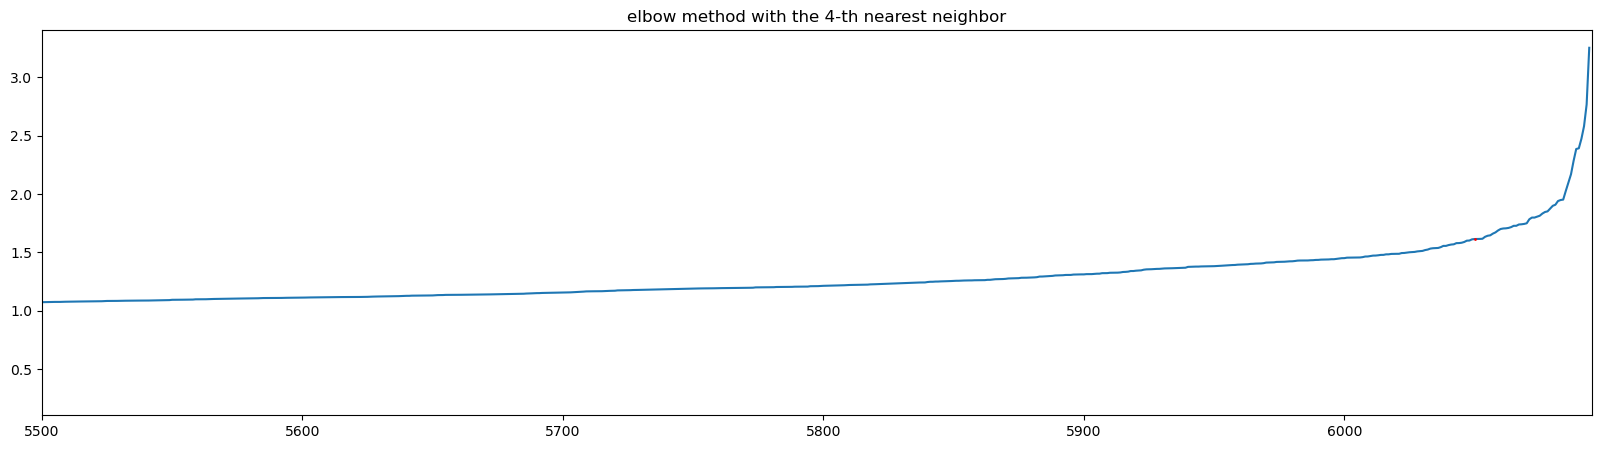

6050 1.6880263399197046


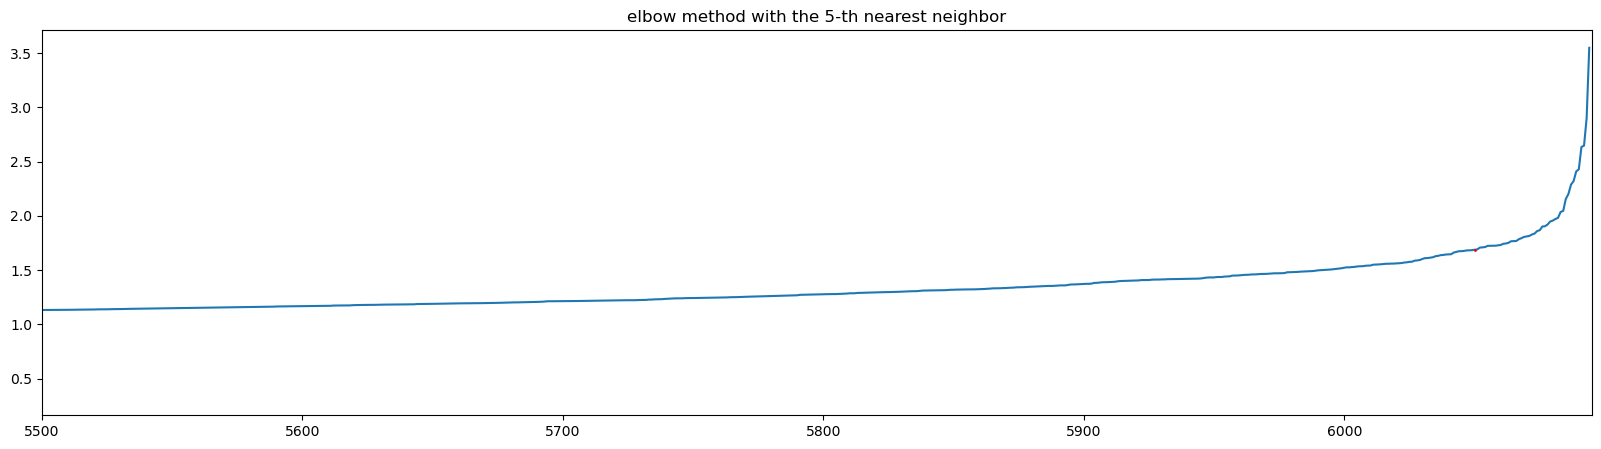

6050 1.9649075593573622


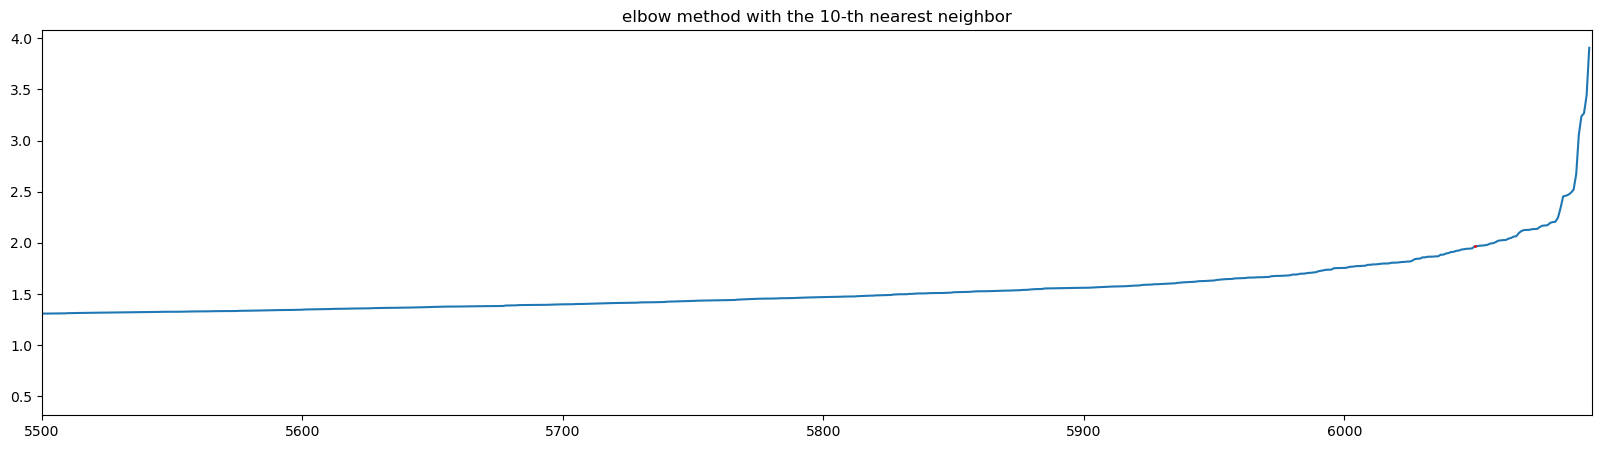

6050 2.9309918869440366


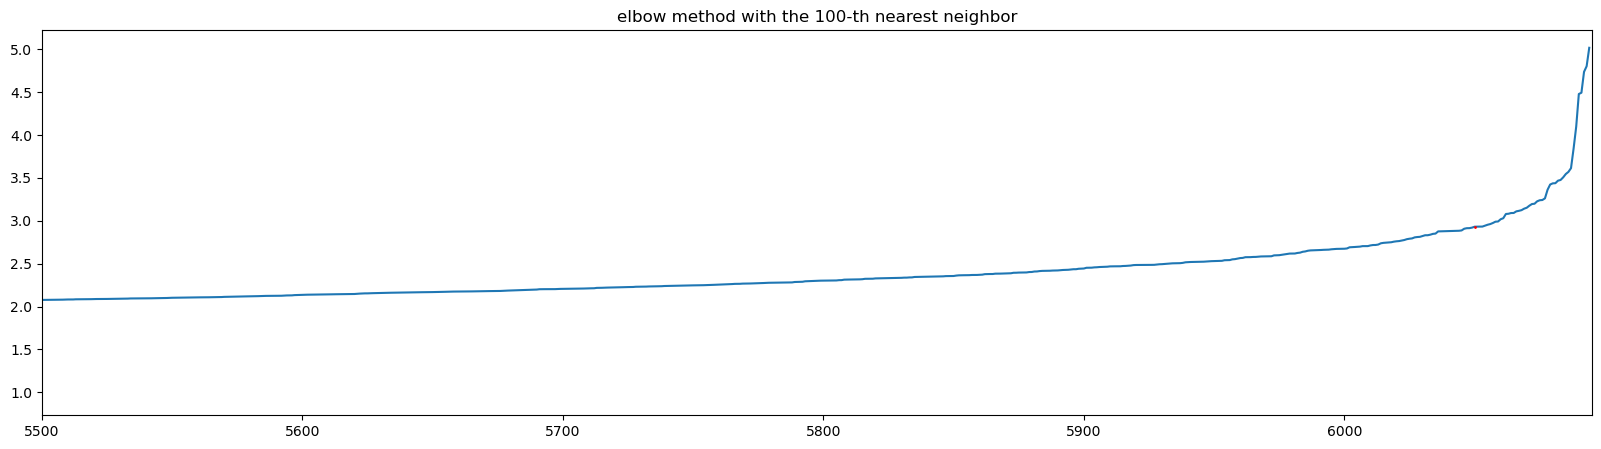

6050 5.410020009063454


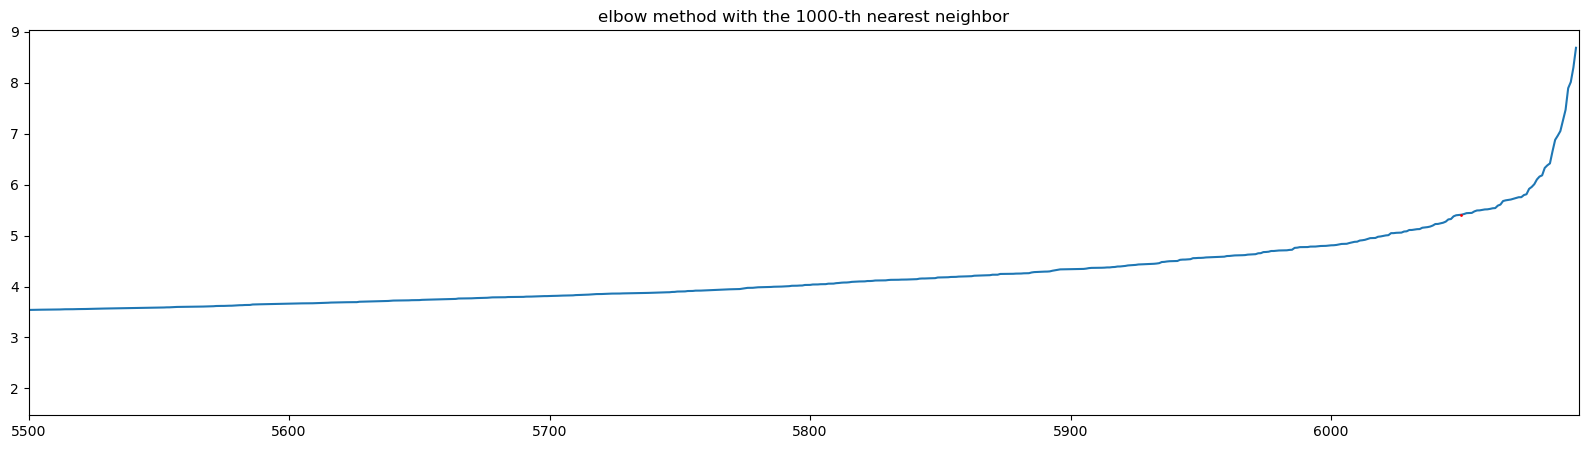

In [25]:
import numpy as np
import matplotlib.pyplot as plt

std_scaler=StandardScaler()
norm_data=std_scaler.fit_transform(cyclists_df)

min_pts=norm_data.shape[0]




nn=NearestNeighbors(n_neighbors=min_pts,n_jobs=-1).fit(norm_data)
distances,indices= nn.kneighbors(norm_data,n_neighbors=min_pts)



sorted_dists=[]

n_dim=norm_data.shape[0]

kth_neighbors=[
    4,
    5,
    10,
    100,
    1000,

]

for k in kth_neighbors:  
    k_distances= np.sort(distances[:,k-1])
    plt.figure(figsize=(20,5))
    plt.plot(k_distances)
    plt.xlim(5500,n_dim)
    plt.plot(6050,k_distances[6050],marker='o',markersize=1,color='red')
    print(6050,k_distances[6050])
    #plt.xlim(294860,len(k_distances))
    plt.title(f"elbow method with the {k}-th nearest neighbor")
    plt.show()
    sorted_dists.append(k_distances)

In [29]:

results_df=utils.run_dbscan(
    min_pts_values=[
        4,
        5,
        10,
        1000
        ],
    eps_values=it.chain(

        1.7*np.array([10,5,2.5,1,0.1,0.01,0.0001]),
        2*np.array([10,5,2.5,1,0.1,0.01,0.0001]),
        3*np.array([10,5,2.5,1,0.1,0.01,0.0001]),
        5.5*np.array([10,5,2.5,1,0.1,0.01,0.0001])
    ),
    metric=['euclidean'],
    clustering_data=norm_data
)

results_df

Running DBSCAN: 0 - eps=17.0, metric=euclidean, min_samples=4
DBSCAN done in 0.66 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 1 - eps=17.0, metric=euclidean, min_samples=5
DBSCAN done in 0.59 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 2 - eps=17.0, metric=euclidean, min_samples=10
DBSCAN done in 0.67 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 3 - eps=17.0, metric=euclidean, min_samples=1000
DBSCAN done in 0.01 seconds | Silhouette Score: all noise
Running DBSCAN: 4 - eps=8.5, metric=euclidean, min_samples=4
DBSCAN done in 0.62 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 5 - eps=8.5, metric=euclidean, min_samples=5
DBSCAN done in 0.61 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 6 - eps=8.5, metric=euclidean, min_samples=10
DBSCAN done in 0.61 seconds | Silhouette Score: -0.3981656348783065
Running DBSCAN: 7 - eps=8.5, metric=euclidean, min_samples=1000
DBSCAN done in 0.01 seconds | Silh

,group_index,eps,metric,min_samples,silhouette_score,execution_time(s)
0,0,17.00000,euclidean,4,-0.398166,0.658686
0,1,17.00000,euclidean,5,-0.398166,0.590532
0,2,17.00000,euclidean,10,-0.398166,0.667241
0,3,17.00000,euclidean,1000,all noise,0.011208
0,4,8.50000,euclidean,4,-0.398166,0.619285
...,...,...,...,...,...,...
0,107,0.05500,euclidean,1000,all noise,0.013042
0,108,0.00055,euclidean,4,all noise,0.012207
0,109,0.00055,euclidean,5,all noise,0.010629
0,110,0.00055,euclidean,10,all noise,0.012087


In [32]:
results_df.loc[results_df['silhouette_score']=='all noise',['silhouette_score']]=-1


results_df[results_df['silhouette_score']>=0].sort_values(by='silhouette_score',ascending=False)

results_df.sort_values(by='silhouette_score',ascending=False)

,group_index,eps,metric,min_samples,silhouette_score,execution_time(s)
0,0,17.00000,euclidean,4,-0.398166,0.658686
0,66,7.50000,euclidean,10,-0.398166,0.629982
0,36,5.00000,euclidean,4,-0.398166,0.624097
0,37,5.00000,euclidean,5,-0.398166,0.615206
0,38,5.00000,euclidean,10,-0.398166,0.620251
...,...,...,...,...,...,...
0,21,0.01700,euclidean,5,-1,0.008492
0,22,0.01700,euclidean,10,-1,0.010537
0,59,30.00000,euclidean,1000,-1,0.008543
0,23,0.01700,euclidean,1000,-1,0.011106
